In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("trip_count_sql").getOrCreate()
spark

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/29 14:50:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
!ls data

1800.csv		    restaurant_reviews.csv  u.data
Book			    taxi+_zone_lookup.csv   xAPI-Edu-Data.csv
fakefriends.csv		    titanic_train.csv
fhvhv_tripdata_2020-03.csv  trips


In [3]:
!pwd

/home/ubuntu/working/spark


In [4]:
directory = "/home/ubuntu/working/spark/data"

trip_files = "trips/*" # 택시 운행 기록 데이터
zone_files = "taxi+_zone_lookup.csv" # 장소 관련 데이터(코드 데이터)

In [5]:
trips_df = spark.read.csv(f"file://{directory}/{trip_files}", inferSchema=True, header=True)
zone_df = spark.read.csv(f"file://{directory}/{zone_files}", inferSchema=True, header=True)

In [6]:
trips_df.printSchema()
zone_df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)

root
 |-- LocationID: integer (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Zone: string (nullable = true)
 |-- service_zone: string (nullable = true)



- `data/trips` 디렉토리가 데이터 레이크의 역할한다.
    - 지금은 로컬에 간단하게 구현을 했지만, 추후 HDFS 등으로 레이크를 구성할 수 있다.

# Data Lake -> Data Warehouse
- 데이터 레이크에 흩어져 있는 데이터를 묶어 주는 역할을 일반적으로 수행
- 연관성 있는 데이터들끼리 분석을 하기 위한 준비 데이터를 마련한다. ( JOIN )

In [7]:
trips_df.createOrReplaceTempView("trips")
zone_df.createOrReplaceTempView("zone")

In [8]:
# Warehouse 생성
query = """
SELECT
    t.VendorID as vendor_id,
    TO_DATE(t.tpep_pickup_datetime) as pickup_date,
    TO_DATE(t.tpep_dropoff_datetime) as dropoff_date,
    HOUR(t.tpep_pickup_datetime) as pickup_time,
    HOUR(t.tpep_dropoff_datetime) as dropoff_time,

    t.passenger_count,
    t.trip_distance,
    t.fare_amount,
    t.tip_amount,
    t.tolls_amount,
    t.total_amount,
    t.payment_type,

    pz.Zone as pickup_zone,
    dz.Zone as dropoff_zone
FROM trips t

LEFT JOIN zone pz ON t.PULocationID = pz.locationID
LEFT JOIN zone dz ON t.DOLocationID = dz.locationID
"""

# comb_df가 warehouse의 역할
comb_df = spark.sql(query)
comb_df.show(10)

+---------+-----------+------------+-----------+------------+---------------+-------------+-----------+----------+------------+------------+------------+--------------------+---------------+
|vendor_id|pickup_date|dropoff_date|pickup_time|dropoff_time|passenger_count|trip_distance|fare_amount|tip_amount|tolls_amount|total_amount|payment_type|         pickup_zone|   dropoff_zone|
+---------+-----------+------------+-----------+------------+---------------+-------------+-----------+----------+------------+------------+------------+--------------------+---------------+
|        2| 2021-03-01|  2021-03-01|          0|           0|              1|          0.0|        3.0|       0.0|         0.0|         4.3|           2|                  NV|             NV|
|        2| 2021-03-01|  2021-03-01|          0|           0|              1|          0.0|        2.5|       0.0|         0.0|         3.8|           2|      Manhattanville| Manhattanville|
|        2| 2021-03-01|  2021-03-01|         

In [9]:
# Warehouse에 SQL을 사용하기 위해 TempView 등록
comb_df.createOrReplaceTempView("comb")

# Data Warehouse -> Data Mart
- 데이터 분석에 필요 없는 데이터를 정제
- 비즈니스에 맞는 데이터만을 남기는 작업
- ex) 2021년 택시 운행 기록에 대한 분석을 해야 하니, Mart에는 2021년 데이터만 남아있을 수 있도록

In [10]:
# 날짜와 시간 검사
query = """
SELECT
    pickup_date, pickup_time
FROM comb
ORDER BY pickup_date
"""
spark.sql(query).show()

+-----------+-----------+
|pickup_date|pickup_time|
+-----------+-----------+
| 2002-12-31|         23|
| 2003-01-05|          7|
| 2004-04-04|          4|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         22|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
+-----------+-----------+
only showing top 20 rows



2021년 이전 데이터 들어 있는 것을 확인

In [11]:
# 2021년 이전 데이터는 몇 건이 있을까?
query = """
SELECT 
    count(*)
FROM comb
WHERE pickup_date < "2021-01-01"
"""
spark.sql(query).show()

+--------+
|count(1)|
+--------+
|     156|
+--------+



In [12]:
# 2. 요금 데이터에 대한 통계 정보 확인
comb_df.select("total_amount").describe().show()

+-------+-----------------+
|summary|     total_amount|
+-------+-----------------+
|  count|         15000700|
|   mean|18.75545205708744|
| stddev|145.7442452805979|
|    min|           -647.8|
|    max|         398469.2|
+-------+-----------------+



최소 값이 음수인 데이터가 있고, 최댓값이 4억원이 넘어가는 데이터도 있다...

In [13]:
# 3. 거리 데이터 확인
comb_df.select("trip_distance").describe().show()

+-------+-----------------+
|summary|    trip_distance|
+-------+-----------------+
|  count|         15000700|
|   mean|6.628629402627818|
| stddev|671.7293482115828|
|    min|              0.0|
|    max|        332541.19|
+-------+-----------------+



In [14]:
# 4. 월 별 은행 수 확인
query = """
SELECT
    DATE_TRUNC("MM", pickup_date) as month,
    COUNT(*) AS trips
FROM comb
GROUP BY month
ORDER BY month DESC
"""

spark.sql(query).show() 

+-------------------+-------+
|              month|  trips|
+-------------------+-------+
|2029-05-01 00:00:00|      1|
|2021-12-01 00:00:00|      5|
|2021-11-01 00:00:00|      5|
|2021-10-01 00:00:00|      3|
|2021-09-01 00:00:00|      3|
|2021-08-01 00:00:00|     36|
|2021-07-01 00:00:00|2821430|
|2021-06-01 00:00:00|2834204|
|2021-05-01 00:00:00|2507075|
|2021-04-01 00:00:00|2171215|
|2021-03-01 00:00:00|1925130|
|2021-02-01 00:00:00|1371688|
|2021-01-01 00:00:00|1369749|
|2020-12-01 00:00:00|     16|
|2009-01-01 00:00:00|    111|
|2008-12-01 00:00:00|     26|
|2004-04-01 00:00:00|      1|
|2003-01-01 00:00:00|      1|
|2002-12-01 00:00:00|      1|
+-------------------+-------+



In [15]:
# 5. 승객 수 확인
import pyspark.sql.functions as F
comb_df.select(F.col("passenger_count")).describe().show()

+-------+------------------+
|summary|   passenger_count|
+-------+------------------+
|  count|          14166672|
|   mean|1.4253783104458126|
| stddev|  1.04432704905968|
|    min|                 0|
|    max|                 9|
+-------+------------------+



살펴본 내용을 토대로 실제 분석할 데이터로 정제. Warehouse -> Mart

In [16]:
# 데이터 정제
query = """
SELECT *

FROM comb c

WHERE c.total_amount < 200
  AND c.total_amount > 0
  AND c.passenger_count < 5
  AND c.pickup_date >= '2021-01-01'
  AND c.pickup_date < '2021-08-01'
  AND c.trip_distance < 10
  AND c.trip_distance > 0
"""

cleaned_df = spark.sql(query)
cleaned_df.createOrReplaceTempView("cleaned")

# 시각화
- 스파크를 사용하는 분산처리 환경에서는 제플린을 활용해서 시각화
- 스파크를 모두 사용하고 나서 판다스 기반의 사각화를 수행할 수도 있다. (Jupyter Notebook)


In [17]:
!pip install seaborn

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
# pickup_date 별 은행 수 확인
query = """
SELECT 
    pickup_date,
    COUNT(pickup_date) as trips
FROM cleaned
GROUP BY pickup_date
"""
pd_df = spark.sql(query).toPandas()
pd_df

,pickup_date,trips
0,2021-03-22,50181
1,2021-03-07,32557
2,2021-03-21,37481
3,2021-05-27,78826
4,2021-03-14,36769
...,...,...
207,2021-03-30,56455
208,2021-03-27,57953
209,2021-03-29,48468
210,2021-04-27,65128


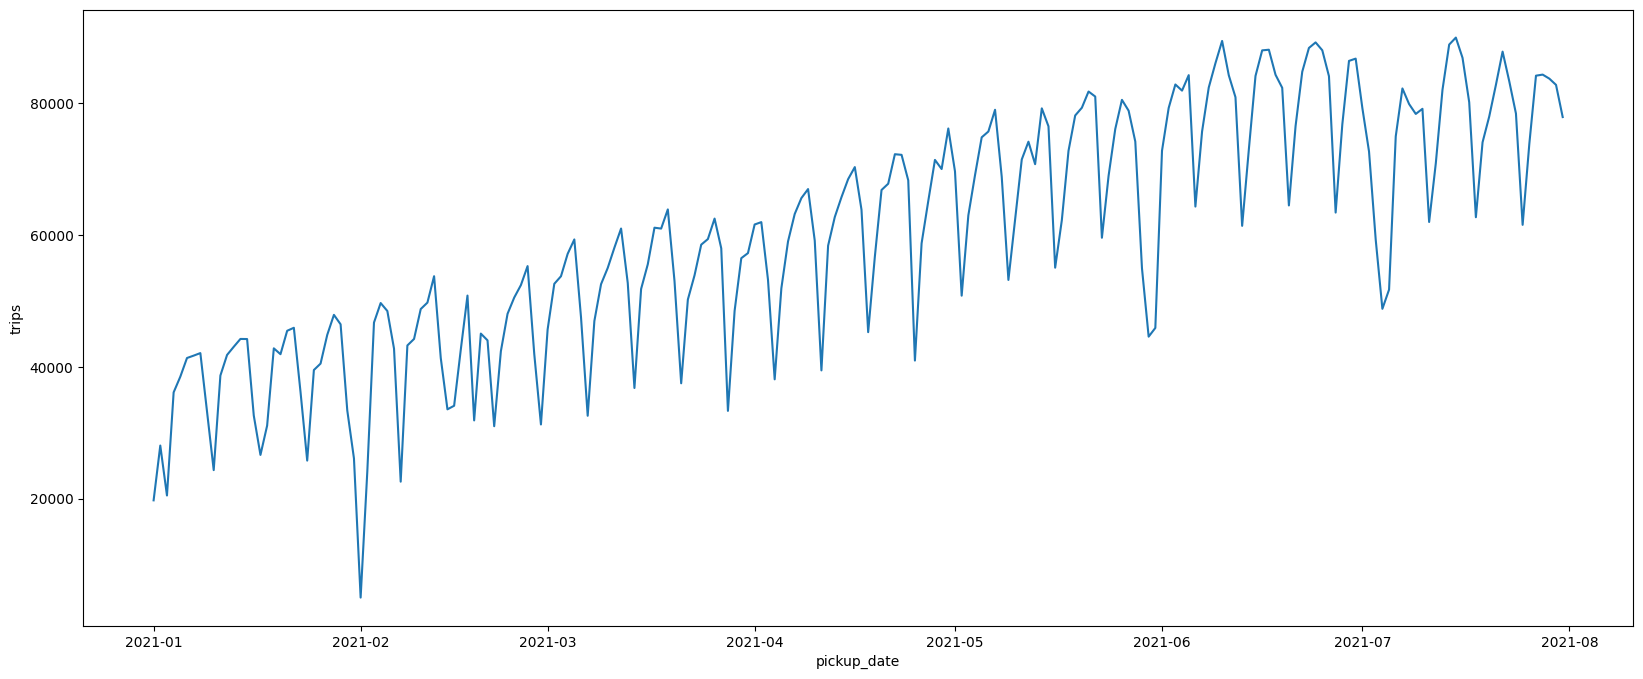

In [20]:
plt.subplots(figsize=(20, 8))

sns.lineplot(
    x="pickup_date",
    y="trips",
    data=pd_df
)
plt.show()

In [23]:
# 요일별 은행 횟수 확인
query = """
SELECT
    DATE_TRUNC("MM", pickup_date) as month,
    DATE_FORMAT(pickup_date, 'EEEE') as day_of_week,
    COUNT(*) as trips
FROM cleaned
GROUP BY month, day_of_week
"""

pd_df2 = spark.sql(query).toPandas()
pd_df2

/home/ubuntu/miniconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:194: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,month,day_of_week,trips
0,2021-03-01,Friday,246564
1,2021-03-01,Sunday,140106
2,2021-03-01,Saturday,211133
3,2021-05-01,Wednesday,307469
4,2021-03-01,Monday,243002
5,2021-02-01,Sunday,118305
6,2021-04-01,Wednesday,267963
7,2021-03-01,Thursday,235457
8,2021-03-01,Tuesday,270928
9,2021-03-01,Wednesday,285498


In [ ]:
plt.subplots(figsize=(20, 8))

sns.lineplot(
    x="month",
    y="trips",
    hue="day_of_week",
    data=pd_df2
)
plt.show()

pd_df2를 활용하기
- 요일별 중간값 구하기
- 중간값 구한 다음 요일로 정렬
    - 일-월-화-수-목-금-토 정렬
- 정렬된 내용을 토대로 Bar 그래프로 나타내기

In [ ]:
# 요일별 중간값 구하기
median_data = pd_df2.groupby("day_of_week")["trips"].median().to_frame()
median_data = median_data.reset_index()
median_data

In [24]:
# 요일 정렬(일월화수목금토)
median_data['sort_dow'] = median_data["day_of_week"].replace({
    "Sunday": 0,
    "Monday": 1,
    "Tuesday": 2,
    "Wednesday": 3,
    "Thursday": 4,
    "Friday": 5,
    "Saturday": 6, 
})
median_data

In [ ]:
median_data_sorted = median_data.sort_values(by='sort_dow')
median_data_sorted

In [ ]:
plt.figure(figsize=(12, 5))
sns.barplot(
    x='day_of_week',
    y='trips',
    data=median_data_sorted
)
plt.show()

In [2]:
spark.stop()

NameError: name 'spark' is not defined